In [1]:
import sys

sys.path.append("../berries")


In [2]:
import random_utils
seed = 0
key_gen = random_utils.infinite_safe_keys(seed)

from datasets import load_dataset
cache_dir="$HOME/.cache/huggingface/datasets"
mnist = load_dataset("mnist", cache_dir=cache_dir, trust_remote_code=True).with_format("jax")
#mnist = load_dataset("fashion_mnist", cache_dir=cache_dir, trust_remote_code=True).with_format("jax")
mnistData = mnist['train']

X_img = mnistData['image']
y = mnistData['label']
X_img_test = mnist["test"]["image"]
n_test_samples = X_img_test.shape[0]
y_test = mnist["test"]["label"]
n_samples, _, _  = X_img.shape
X_train = X_img.reshape((n_samples, 1, 28, 28))
X_test = X_img_test.reshape((n_test_samples, 1, 28, 28))
n_channels = 1
d_x = (28, 28)
d_y = len(set(y.tolist()))

In [9]:
from jax.image import resize
from jax.numpy import int32, int64
from pf import F, _
from plot_utils import visualize_matrix
from IPython.display import display

q_x1 = 16
q_x2 = 16
n_x_q = 8

def quantize(x):
    x = (F(resize).vmap((0, None, None), 0)(x, (1, q_x1, q_x2), "bilinear") + n_x_q//2) // (256 // n_x_q) 
    return int32(x)

X_train_q = quantize(X_train)
X_test_q = quantize(X_test)
n_codes_x = q_x1*q_x2
n_nodes_x = n_x_q*n_codes_x
print(n_nodes_x)

2048


In [8]:
from jax import jit, vmap, numpy as np

def coords_to_index(x1, x2, v):
    index = ((x1 * q_x2) + x2) * n_x_q + v
    return index

def index_to_coords(index):
    x1 = index // (n_x_q * q_x2)
    remainder = index % (n_x_q * q_x2)
    x2 = remainder // n_x_q
    v = remainder % n_x_q
    return x1, x2, v

idx_x1 = np.arange(q_x1)
idx_x2 = np.arange(q_x2)
ii, jj = np.meshgrid(idx_x1, idx_x2, indexing='ij')
def encode(x):
    return coords_to_index(ii, jj, x).ravel()

encode_all = vmap(encode, in_axes=0, out_axes=0)

X_train_code = encode_all(X_train_q)
X_test_code = encode_all(X_test_q)
print(X_train_code.shape)


(60000, 256)


In [22]:
y[:2, np.newaxis].repeat(2, axis=1).ravel()


Array([5, 5, 0, 0], dtype=int32)

In [23]:
from jax.nn import softmax
from tqdm import tqdm
top_quantile = 0.8
train_batch_size = 128
test_batch_size = 256
add_val = 1

def update_Wy_code(Wy, x_code, y):
    return Wy.at[x_code, y].add(add_val)

def update_Wy_code_att(Wy, x_code, y):
    threshold = np.quantile(Wy, top_quantile)
    return Wy.at[x_code, y].add(add_val*(Wy[x_code, y] > threshold))

def update_Wy_code_att_ave(Wy, x_code, y):
    sync = Wy[x_code, y]
    quantile = avg_per_node
    threshold = np.quantile(Wy, quantile)
    return Wy.at[x_code, y].add(add_val*(sync > threshold))

def update_Wy_code_att_static(Wy, x_code, y):
    return Wy.at[x_code, y].add(add_val*(Wy[x_code, y] > threshold_))

def batchfy_update(update):
    def update_batch(Wy, X_code, y):
        X_code = X_code.ravel()
        y = y[:, np.newaxis].repeat(n_codes_x, axis=1).ravel()
        return update(Wy, X_code, y)
    return update_batch

def predict(Wy, x_code):
    return Wy[x_code, :].mean(axis=0).argmax()

def accuracy_batch(Wy, X_code, y):
    for i in tqdm(range(0, n_test_samples, test_batch_size)):
        y_pred = vmap(predict, in_axes=(None, 0))(Wy, X_code[i:i+test_batch_size, :])
        accuracy = (y_pred == y[i:i+test_batch_size]).mean()
    return accuracy

def train(update, Wy, X, y):
    for i in tqdm(range(0, n_samples)):
        Wy = jit(update)(Wy, X[i, :], y[i])
    return Wy

def train_batch(update, Wy, X, y):
    for i in tqdm(range(0, n_samples, train_batch_size)):
        Wy = jit(batchfy_update(update))(Wy, X[i:i+train_batch_size, :], y[i:i+train_batch_size])
    return Wy

Wy = np.zeros((n_nodes_x, d_y))
# X_train_code[0, :], y[0]
# Wyy = Wy.at[X_train_code[0, :], y[0]].add(1)
print("Training Wy")
acc0 = accuracy_batch(Wy/np.linalg.norm(Wy, axis=0, keepdims=True), X_test_code, y_test)
print("init accuracy", acc0)

Wy1 = train_batch(update_Wy_code, Wy, X_train_code, y)
acc1 = accuracy_batch(Wy1/np.linalg.norm(Wy1, axis=0, keepdims=True), X_test_code, y_test)
print("Wy1 accuracy", acc1)
print(np.linalg.norm(Wy1, axis=0, keepdims=True))
print(Wy1[0, :])

# Wy2 = train(update_Wy_code_att, Wy1, X_train_code, y)
# print("Wy2 accuracy", accuracy_batch(Wy2/np.linalg.norm(Wy2, axis=0, keepdims=True), X_test_code, y_test))


threshold_ = np.quantile(Wy1, 0.8)
Wy3 = train(update_Wy_code_att_static, Wy1, X_train_code, y)
print("Wy3 accuracy", accuracy_batch(Wy3/np.linalg.norm(Wy3, axis=0, keepdims=True), X_test_code, y_test))


Training Wy


100%|██████████| 40/40 [00:00<00:00, 164.64it/s]


init accuracy 0.0625


100%|██████████| 40/40 [00:00<00:00, 218.32it/s]


Wy1 accuracy 0.8125
[[76515.125 98380.53  77871.19  81090.    79169.836 71611.41  79539.4
  86180.164 77380.22  81232.71 ]]
[5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]


100%|██████████| 40/40 [00:00<00:00, 188.01it/s]

Wy3 accuracy 0.875


In [39]:
def get_mean_sample_conn(W, x, y):
    return W[x.ravel(), y[:, np.newaxis].repeat(n_codes_x, axis=1).ravel()].reshape((n_codes_x, -1)).mean(axis=0)

all_conns = Wy1m[X_test_code.ravel(), y_test[:, np.newaxis].repeat(n_codes_x, axis=1).ravel()]
all_conns.reshape((n_codes_x, -1)).sum(axis=0).shape

(10000,)

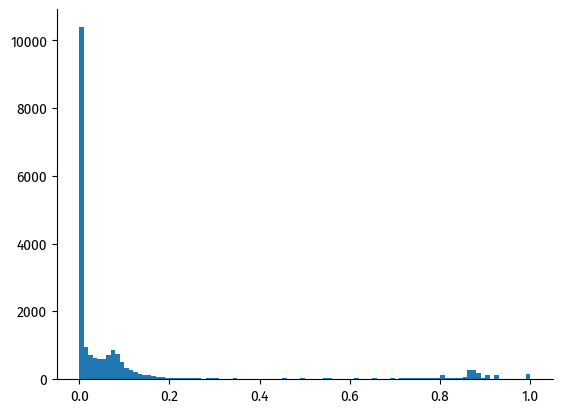

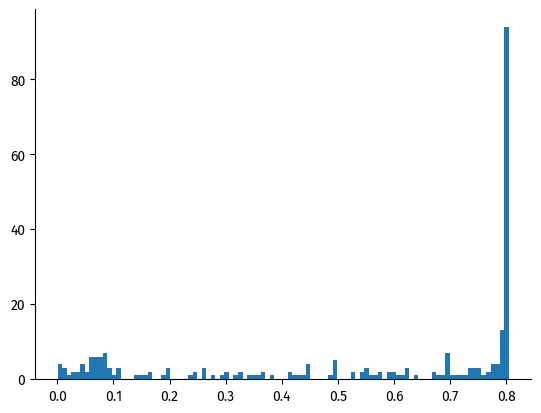

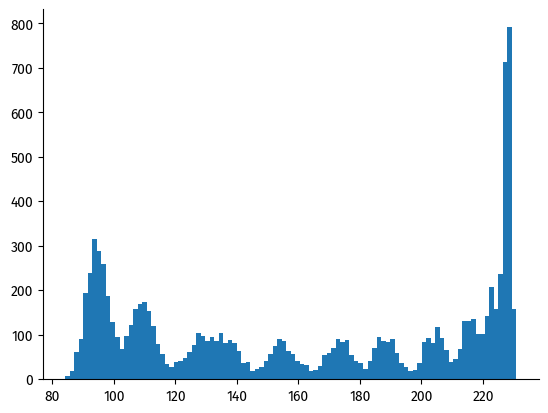

In [38]:
Wy1m = Wy1/Wy1.max()
import matplotlib.pyplot as plt
plt.hist(Wy1m.ravel(), bins=100)
plt.show()
plt.hist(Wy1m[X_test_code[0, :], y[0]].ravel(), bins=100)
plt.show()
plt.hist(all_conns.reshape((n_codes_x, -1)).sum(axis=0), bins=100)
plt.show()

In [17]:
# Predefined shape of A1

i, j, k, l = np.meshgrid(idx_x1, idx_x1, idx_x2, idx_x2, indexing='ij')
W = np.zeros((n_nodes_x, n_nodes_x))




def update_W(W, x):
    index1 = coords_to_index(i, j, x[i, j]).ravel()
    index2 = coords_to_index(k, l, x[k, l]).ravel()
    W = W.at[index1, index2].add(1)
    return W

def update_Wy(Wy, x, y):
    index1 = coords_to_index(i, j, x[i, j]).ravel()
    Wy = Wy.at[index1, y].add(1)
    return Wy

def update_Wy_att(Wy, x, y):
    threshold = np.quantile(Wy, top_quantile)
    index1 = coords_to_index(i, j, x[i, j]).ravel()
    print(index1.shape)
    for ii in range(n_nodes_x):
        if Wy[index1[ii], y] > threshold:
            Wy = Wy.at[index1[ii], y].add(1)
    return Wy


update_W_vectorized = vmap(update_W, in_axes=(None, 0))
update_Wy_vectorized = vmap(update_Wy, in_axes=(None, 0, 0))

print(W.sum())


def train_W(W, X):
    for i in range(0, n_samples, batch_size):
        batch = X[i:i + batch_size, :, :]
        W = jit(update_W_vectorized)(W, batch)
    return W

def train_W1(W, X):
    for i in tqdm(range(0, n_samples)):
        W = jit(update_W)(W, X[i, :, :])
    return W

def train_Wy1(Wy, X, y):
    for i in tqdm(range(0, n_samples)):
        Wy = jit(update_Wy)(Wy, X[i, :, :], y[i])
    return Wy

def train_Wy1_att(Wy, X, y):
    for i in tqdm(range(0, n_samples)):
        Wy = jit(update_Wy_att)(Wy, X[i, :, :], y[i])
    return Wy

# W = train_W1(W, X_train_q)
# Wy1 = train_Wy1(Wy, X_train_q, y)
Wy2 = train_Wy1_att(Wy, X_train_q, y)


0.0


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

(1048576,)


TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function update_Wy_att at /tmp/ipykernel_9891/2944994897.py:34 for jit. This concrete value was not available in Python because it depends on the values of the arguments Wy, x, and y.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [13]:
m = X_test_q[0, :]
def predict(Wy, m):
    Wy_norm = Wy / Wy.sum(axis=1, keepdims=True)
    ii, jj = np.meshgrid(idx_x1, idx_x2, indexing='ij')
    mi = coords_to_index(ii, jj, m).ravel()
    return Wy_norm[mi, :].sum(axis=0).argmax()

batch_size = 256
@jit
def predict_all(Wy, X):
    return np.array([predict(Wy, x) for x in X])

def predict_all_batch(Wy, X):
    v_predict = vmap(predict, in_axes=(None, 0))
    for i in tqdm(range(0, X.shape[0], batch_size)):
        batch = X[i:i + batch_size, :, :]
        if i == 0:
            predictions = v_predict(Wy, batch)
        else:
            predictions = np.concatenate((predictions, v_predict(Wy, batch)))
    return predictions

def accuracy(Wy, X, y):
    return (predict_all(Wy, X) == y).mean()

def accuracy_batch(Wy, X, y):
    return (predict_all_batch(Wy, X) == y).mean()

print(accuracy_batch(Wy, X_test_q, y_test))
print(accuracy_batch(Wy, X_train_q, y))

100%|██████████| 40/40 [00:00<00:00, 141.80it/s]


0.3985


100%|██████████| 235/235 [00:07<00:00, 33.08it/s]

0.40951666


In [36]:
import numpy as np

def create_B1_matrix(A1):
    m, n = A1.shape
    idx_m = np.arange(m)
    idx_n = np.arange(n)
    B1 = np.zeros((4 * m * n, 4 * m * n), dtype=int)

    i, j, k, l = np.meshgrid(idx_m, idx_n, idx_m, idx_n, indexing='ij')

    value1 = A1[i, j]
    value2 = A1[k, l]

    index1 = ((i * n + j) * 4 + value1).ravel()
    index2 = ((k * n + l) * 4 + value2).ravel()

    B1[index1, index2] = 1

    return B1

# Example usage
A1 = np.array([[1, 0, 2], [2, 3, 1]])
B1 = create_B1_matrix(A1)

# Print the resulting B1 matrix
print(B1)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 1 0 0 0 1